# Exploring LSTM models 

In this notebook we run lstm models on Infodengue data.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)
#from infodengue import get_temperature_data, get_alerta_table, get_tweet_data, combined_data, get_cluster_data
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

Using TensorFlow backend.


PSQL_USER not found. Declare it as envvar or define a default value.


## Loading the data

To download the data we follow the instructions in the [README.rst](https://github.com/fccoelho/InfoDenguePredict/blob/master/README.rst) file.

We perform our experiments on data from Rio de Janeiro. Let us first read all our data.

In [2]:
data_cluster = pd.read_csv("~/data/infodengue/3304557_cluster.csv",index_col=0)
data_cluster.head()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2010-01-03,1,1.0,1,1,0.0,2.80725,24.333333,33.000000,42.000000,1009.666667,...,3,3.0,3,3,0.0,0.607114,24.333333,33.000000,42.000000,1009.666667
2010-01-10,0,0.0,0,0,0.0,0.00000,25.428571,34.000000,43.285714,1008.000000,...,6,6.0,6,6,0.0,1.214230,25.428571,34.000000,43.285714,1008.000000
2010-01-17,0,0.0,0,0,0.0,0.00000,24.142857,34.000000,43.857143,1010.285714,...,1,1.0,1,1,0.0,0.202371,24.142857,34.000000,43.857143,1010.285714
2010-01-24,0,0.0,0,0,0.0,0.00000,23.714286,34.285714,39.285714,1009.000000,...,4,4.0,4,4,0.0,0.809486,23.714286,34.285714,39.285714,1009.000000
2010-01-31,0,0.0,0,0,0.0,0.00000,23.857143,33.857143,41.285714,1009.857143,...,9,9.0,9,9,0.0,1.821340,23.857143,33.857143,41.285714,1009.857143


The city of Rio is coded as cluster `3304557`. We can easily filter the dataframe above to get only the data corresponding to this cluster.

In [3]:
data_cluster.tail()

,casos_3306206,casos_est_3306206,casos_est_min_3306206,casos_est_max_3306206,p_rt1_3306206,p_inc100k_3306206,temp_min_3306206,temp_max_3306206,umid_min_3306206,pressao_min_3306206,...,casos_3300456,casos_est_3300456,casos_est_min_3300456,casos_est_max_3300456,p_rt1_3300456,p_inc100k_3300456,temp_min_3300456,temp_max_3300456,umid_min_3300456,pressao_min_3300456
2019-04-14,3,3.0,3,3,0.123280,8.42176,23.428571,25.285714,85.986071,1012.857143,...,4,4.0,4,4,0.015841,0.809486,23.428571,25.285714,85.986071,1012.857143
2019-04-21,3,3.0,3,3,0.173497,8.42176,22.571429,25.571429,76.046814,1011.857143,...,0,0.0,0,0,0.000000,0.000000,22.571429,25.571429,76.046814,1011.857143
2019-04-28,11,12.0,11,13,0.958076,33.68700,23.857143,26.857143,78.433171,1013.428571,...,0,0.0,0,0,0.000000,0.000000,23.857143,26.857143,78.433171,1013.428571
2019-05-05,15,20.0,16,21,0.995579,56.14510,23.142857,25.857143,80.172271,1013.000000,...,0,0.0,0,0,0.000000,0.000000,23.142857,25.857143,80.172271,1013.000000
2019-05-12,8,14.0,10,15,0.734682,39.30160,22.142857,24.857143,77.838957,1014.000000,...,0,0.0,0,0,0.000000,0.000000,22.142857,24.857143,77.838957,1014.000000


In [4]:
cluster_rj = data_cluster[[c for c in data_cluster.columns if "3304557" in c.split("_")]]
print(cluster_rj.shape)
print(cluster_rj.columns)
cluster_rj.head()

(488, 10)
Index(['casos_3304557', 'casos_est_3304557', 'casos_est_min_3304557',
       'casos_est_max_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557'],
      dtype='object')


,casos_3304557,casos_est_3304557,casos_est_min_3304557,casos_est_max_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,30.0,30,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,46.0,46,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,30.0,30,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,51.0,51,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,58.0,58,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


Our goal is to predict the first column, `casos_3304557` from the columns `p_rt1_3304557`, `p_inc100k_3304557`, `temp_min_3304557`, `temp_max_3304557`, `umid_min_3304557`, `pressao_min_3304557`.

In [5]:
usecols = ['casos_3304557', 'p_rt1_3304557', 'p_inc100k_3304557',
       'temp_min_3304557', 'temp_max_3304557', 'umid_min_3304557',
       'pressao_min_3304557']
data = cluster_rj[usecols]
timestamps = pd.to_datetime(data.index)
data.head()


,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
2010-01-03,30,0.0,0.461621,24.333333,33.000000,42.000000,1009.666667
2010-01-10,46,0.0,0.707819,25.428571,34.000000,43.285714,1008.000000
2010-01-17,30,0.0,0.461621,24.142857,34.000000,43.857143,1010.285714
2010-01-24,51,0.0,0.784756,23.714286,34.285714,39.285714,1009.000000
2010-01-31,58,0.0,0.892467,23.857143,33.857143,41.285714,1009.857143


In [6]:
timestamps

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

Let us plot the features of our dataset.

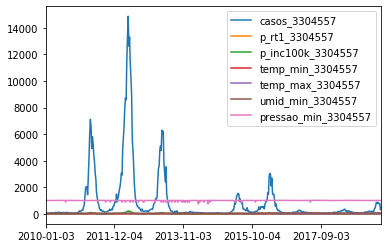

In [7]:
data.plot()

## Normalizing and splitting train/tests sets

In [8]:
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=pd.to_datetime(data.index)
data.head()

,casos_3304557,p_rt1_3304557,p_inc100k_3304557,temp_min_3304557,temp_max_3304557,umid_min_3304557,pressao_min_3304557
1970-01-01 00:00:00.000000000,0.002018,0.0,0.002018,0.920721,0.891892,0.488451,0.982712
1970-01-01 00:00:00.000000001,0.003094,0.0,0.003094,0.962162,0.918919,0.503404,0.981090
1970-01-01 00:00:00.000000002,0.002018,0.0,0.002018,0.913514,0.918919,0.510049,0.983315
1970-01-01 00:00:00.000000003,0.003430,0.0,0.003430,0.897297,0.926641,0.456885,0.982063
1970-01-01 00:00:00.000000004,0.003901,0.0,0.003901,0.902703,0.915058,0.480144,0.982898


In [9]:
max_values

casos_3304557          14868.000000
p_rt1_3304557              1.000000
p_inc100k_3304557        228.779000
temp_min_3304557          26.428571
temp_max_3304557          37.000000
umid_min_3304557          85.986071
pressao_min_3304557     1027.428571
dtype: float64

In [10]:
min_values

casos_3304557           17.000000
p_rt1_3304557            0.000000
p_inc100k_3304557        0.261585
temp_min_3304557        14.285714
temp_max_3304557        17.714286
umid_min_3304557        20.428571
pressao_min_3304557    752.714286
dtype: float64

In [11]:
np.min(data,axis=0)

casos_3304557          0.001143
p_rt1_3304557          0.000000
p_inc100k_3304557      0.001143
temp_min_3304557       0.540541
temp_max_3304557       0.478764
umid_min_3304557       0.237580
pressao_min_3304557    0.732620
dtype: float64

In [12]:
np.min(data,axis=0).iloc[0]*max_values.iloc[0]

17.0

In [13]:
data.index = timestamps

In [14]:
data.index

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31',
               '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-28',
               '2019-05-05', '2019-05-12'],
              dtype='datetime64[ns]', length=488, freq=None)

In [15]:
### Splitting train/test sets
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.5, predict_n=1, Y_column=0)
#timestamps_train = 

234


We are looking back 10 weeks to get our training data:

In [16]:
X_train.shape

(234, 10, 7)

In [17]:
X_test.shape

(244, 10, 7)

In [18]:
y_train.shape

(234, 1)

In [19]:
y_test.shape

(244, 1)

## LSTM model
An LSTM model can be retrieved from `lstm.py`.

In [183]:
model = build_model(hidden=4, features=7, predict_n=1, look_back=10, batch_size=39)

Compilation Time :  0.025264978408813477
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (39, 10, 7)               0         
_________________________________________________________________
lstm_43 (LSTM)               (39, 10, 4)               192       
_________________________________________________________________
dropout_43 (Dropout)         (39, 10, 4)               0         
_________________________________________________________________
lstm_44 (LSTM)               (39, 10, 4)               144       
_________________________________________________________________
dropout_44 (Dropout)         (39, 10, 4)               0         
_________________________________________________________________
lstm_45 (LSTM)               (39, 4)                   144       
_________________________________________________________________
dropout_45 (Dropout)         (39, 4

### Training model

In [184]:
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=3304557, overwrite=True)

../infodenguepredict/models/deeplearning/lstm.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, EarlyStopping(patience=15)]


Train on 198 samples, validate on 36 samples
Epoch 1/20
198/198 [==============================] - 10s 50ms/step - loss: 0.0223 - acc: 0.0000e+00 - mean_absolute_percentage_error: 495.2042 - mean_squared_error: 0.0382 - val_loss: 0.0056 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 1302.0920 - val_mean_squared_error: 0.0063
Epoch 2/20
198/198 [==============================] - 7s 36ms/step - loss: 0.0145 - acc: 0.0000e+00 - mean_absolute_percentage_error: 407.1885 - mean_squared_error: 0.0258 - val_loss: 0.0046 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 921.9156 - val_mean_squared_error: 0.0054
Epoch 3/20
198/198 [==============================] - 6s 30ms/step - loss: 0.0111 - acc: 5.1800e-04 - mean_absolute_percentage_error: 316.0347 - mean_squared_error: 0.0197 - val_loss: 0.0018 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 663.8745 - val_mean_squared_error: 0.0020
Epoch 4/20
198/198 [==============================] - 4s 22ms/step - loss:

#### Training history

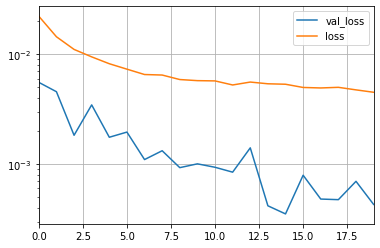

In [220]:
plot_training_history(hist)

#### Plotting predictions 

In [231]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import os
#os.chdir("..")

import sys
sys.path.append('../')
from infodenguepredict.models.deeplearning.lstm import *
#plot_predicted_vs_data, loss_and_metrics, evaluate, calculate_metrics, train_evaluate_model, 
#from infodenguepredict.models.deeplearning.preprocessing import *
#from infodenguepredict.models.deeplearning.lstm import lstm.build_model
#try:
#    from infodenguepredict.models.deeplearning.lstm import *
#except Exception as e:
#    print(e)
#from infodengue import get_temperature_data, get_alerta_table, get_tweet_data, combined_data, get_cluster_data
import pickle
import getpass, os
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import backend as K
from sklearn.metrics import *
import pandas as pd
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
index[split_point]

Timestamp('2014-09-07 00:00:00')

In [233]:
#Xdata = np.concatenate((X_train,X_test))
#n_predictions=10
#a = predict_with_dropout(model,Xdata,n_predictions,batch_size=1)
#Xdata.shape

In [234]:
a

array([[[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       ...,

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.        , -0.        , -0.        , ...,  0.02637035,
         -0.        , -0.        ]]], dtype=float32)

In [236]:
n_predictions=10
Xdata = np.concatenate((X_train,X_test))
predicted = predict_with_dropout(model,Xdata,n_predictions,hidden=4,features=7,predict_n=1,look_back=10,\
                         batch_size=478)
Ydata = np.concatenate((y_train,y_test))
index = data.index


Compilation Time :  0.025307893753051758
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (478, 10, 7)              0         
_________________________________________________________________
lstm_79 (LSTM)               (478, 10, 4)              192       
_________________________________________________________________
dropout_79 (Dropout)         (478, 10, 4)              0         
_________________________________________________________________
lstm_80 (LSTM)               (478, 10, 4)              144       
_________________________________________________________________
dropout_80 (Dropout)         (478, 10, 4)              0         
_________________________________________________________________
lstm_81 (LSTM)               (478, 4)                  144       
_________________________________________________________________
dropout_81 (Dropout)         (478, 

100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


In [238]:
predicted.shape

(10, 478, 1)

df_predicted_shape:  (478, 1)
df_predicted:              0
0   -0.000000
1    0.004358
2    0.000655
3   -0.000000
4   -0.000000
5    0.009776
6   -0.000000
7    0.007594
8   -0.000000
9   -0.000000
10  -0.000000
11  -0.000000
12   0.012383
13   0.011392
14  -0.000000
15  -0.000000
16  -0.000000
17  -0.000000
18  -0.000000
19  -0.000000
20   0.002686
21   0.002404
22  -0.000000
23  -0.000000
24  -0.000000
25  -0.000000
26   0.010608
27  -0.000000
28  -0.000000
29  -0.000000
..        ...
448 -0.000000
449 -0.000000
450 -0.000000
451  0.003529
452 -0.000000
453 -0.000000
454  0.010925
455 -0.000000
456  0.002162
457  0.002062
458  0.017100
459  0.008986
460 -0.000000
461 -0.000000
462  0.002140
463 -0.000000
464 -0.000000
465 -0.000000
466 -0.000000
467 -0.000000
468 -0.000000
469  0.003970
470 -0.000000
471  0.014657
472 -0.000000
473  0.046470
474  0.047272
475  0.060118
476  0.076488
477  0.080955

[478 rows x 1 columns]
CPU times: user 9.91 ms, sys: 10.6 ms, total: 20.5 ms
Wall time

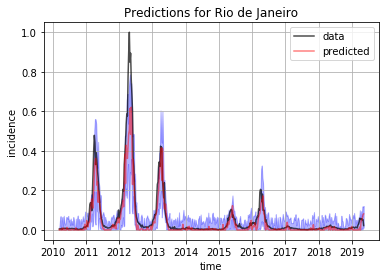

In [239]:
%%time
#y_pred_train = model.predict(X_train,batch_size=1)
#y_pred_test = model.predict(X_test,batch_size=1)
#predicted = np.concatenate((y_pred_train,y_pred_test))
#Xdata = np.concatenate((X_train,X_test))
#predicted = predict_with_dropout(model,Xdata,n_predictions,batch_size=1)
#Ydata = np.concatenate((y_train,y_test))
#index = data.index
label="Rio de Janeiro"
pred_window=1
factor=1
#split_point = int(len(indice)*0.5)
ratio = 0.5
plot_predicted_vs_data(predicted, Ydata, index, label, ratio, factor=1, look_back =10,\
                           pred_window =1)

In [209]:
model.predict(X_train,batch_size=1)

ValueError: could not broadcast input array from shape (39,1) into shape (1,1)

In [ ]:
Ydata.shape

In [ ]:
a.shape

In [ ]:
Ydata.shape

In [24]:
X, y = np.concatenate((X_train,X_test), axis=0), np.concatenate((y_train,y_test),axis=0)*max_values.iloc[0]

timestamps = data.index[:len(X)]
predictions = make_predictions_batch(X, model, hidden=4, features=7, predict_n = 1, look_back=10,\
                                          batch_size=478,n_pred = 100)*max_values.iloc[0]
fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,timestamps, predictions[:,:,0],y[:,0],\
               axvline_kw={"x": timestamps[len(X_train)], "linestyle": "dashdot", "ymin":0.05,"ymax":1, "color": "g", "label":"train/test split"})
fig.savefig("../figures/LSTM_dropout.png")

NameError: name 'make_predictions_batch' is not defined

## Nova Iguaçu

Let us now train a model for Nova Iguaçu

In [60]:
os.environ['PSQL_USER']='dengue_ro'
os.environ['PSQL_HOST']='localhost'
os.environ['PSQL_DB']='dengue_ro'
os.environ['PSQL_PASSWORD']=getpass.getpass("Enter the database password: ")

Enter the database password: ········


#### Getting and normalizing  dengue data

In [61]:
geocodes = {"rio": 3304557, "n_iguacu": 3303500}
features = ['casos_', 'p_rt1_', 'p_inc100k_',
       'temp_min_', 'temp_max_', 'umid_min_',
       'pressao_min_']
usecols = [f + str(geocodes["n_iguacu"]) for f in features]
df, _ = get_cluster_data(geocodes["n_iguacu"], clusters=[], data_types=["alerta", "weather"], \
                 cols=None, save=False, doenca='dengue')
data=df.loc[:,usecols]
timestamps=data.index
#data = df[usecols]
### Normalizing data
min_values = np.min(data,axis=0)
max_values = np.max(data,axis=0)
data, _ = normalize_data(data)
data.index=timestamps
print("Shape of data: ", data.shape)
data.head()
#df

Shape of data:  (282, 7)


,casos_3303500,p_rt1_3303500,p_inc100k_3303500,temp_min_3303500,temp_max_3303500,umid_min_3303500,pressao_min_3303500
2012-01-01,0.129338,0.996510,0.129337,0.863720,0.780804,0.715183,0.982919
2012-01-08,0.201893,0.999718,0.201892,0.839779,0.782101,0.645548,0.986736
2012-01-15,0.160883,0.814445,0.160883,0.895028,0.856031,0.535959,0.988271
2012-01-22,0.274448,0.997989,0.274448,0.906077,0.871595,0.537671,0.987434
2012-01-29,0.315457,0.997224,0.315457,0.856354,0.809339,0.611301,0.987154


#### Splitting train/test sets

In [62]:
X_train, y_train, X_test, y_test = split_data(data, look_back=10, ratio=0.75, predict_n=1, Y_column=0)
print("X_train shape: {}\t y_train shape: {}\n".format(X_train.shape,y_train.shape))
print("X_test shape: {}\t y_test shape: {}\n".format(X_test.shape,y_test.shape))

train size:  201
X_train shape: (201, 10, 7)	 y_train shape: (201, 1)

X_test shape: (71, 10, 7)	 y_test shape: (71, 1)



#### Running model

In [63]:
batch_size=67
model = build_model(hidden=4, features=7, predict_n=1, look_back=10, batch_size=batch_size)
hist = train(model, X_train, y_train, batch_size=1, epochs=20, geocode=geocodes["n_iguacu"], overwrite=True)

Compilation Time :  0.024903059005737305
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (67, 10, 7)               0         
_________________________________________________________________
lstm_31 (LSTM)               (67, 10, 4)               192       
_________________________________________________________________
dropout_31 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_32 (LSTM)               (67, 10, 4)               144       
_________________________________________________________________
dropout_32 (Dropout)         (67, 10, 4)               0         
_________________________________________________________________
lstm_33 (LSTM)               (67, 4)                   144       
_________________________________________________________________
dropout_33 (Dropout)         (67, 4

/home/rio/geomed/Analysis/lstm.py:173: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  callbacks=[TB_callback, es, cp]


Train on 170 samples, validate on 31 samples
Epoch 1/20
170/170 [==============================] - 8s 46ms/step - loss: 0.0299 - acc: 0.0059 - mean_absolute_percentage_error: 790620.7878 - mean_squared_error: 0.0529 - val_loss: 0.0108 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 268.6704 - val_mean_squared_error: 0.0147
Epoch 2/20
170/170 [==============================] - 5s 32ms/step - loss: 0.0255 - acc: 0.0059 - mean_absolute_percentage_error: 547584.9587 - mean_squared_error: 0.0460 - val_loss: 0.0101 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 159.8642 - val_mean_squared_error: 0.0141
Epoch 3/20
170/170 [==============================] - 6s 37ms/step - loss: 0.0186 - acc: 0.0059 - mean_absolute_percentage_error: 247072.2046 - mean_squared_error: 0.0349 - val_loss: 0.0105 - val_acc: 0.0000e+00 - val_mean_absolute_percentage_error: 168.2371 - val_mean_squared_error: 0.0151
Epoch 4/20
170/170 [==============================] - 4s 24ms/step - loss: 0.01

#### Plotting results 
Note that we reload and recompile the trained model.

Compilation Time :  0.02573227882385254
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (1, 10, 7)                0         
_________________________________________________________________
lstm_40 (LSTM)               (1, 10, 4)                192       
_________________________________________________________________
dropout_40 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_41 (LSTM)               (1, 10, 4)                144       
_________________________________________________________________
dropout_41 (Dropout)         (1, 10, 4)                0         
_________________________________________________________________
lstm_42 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dropout_42 (Dropout)         (1, 4) 

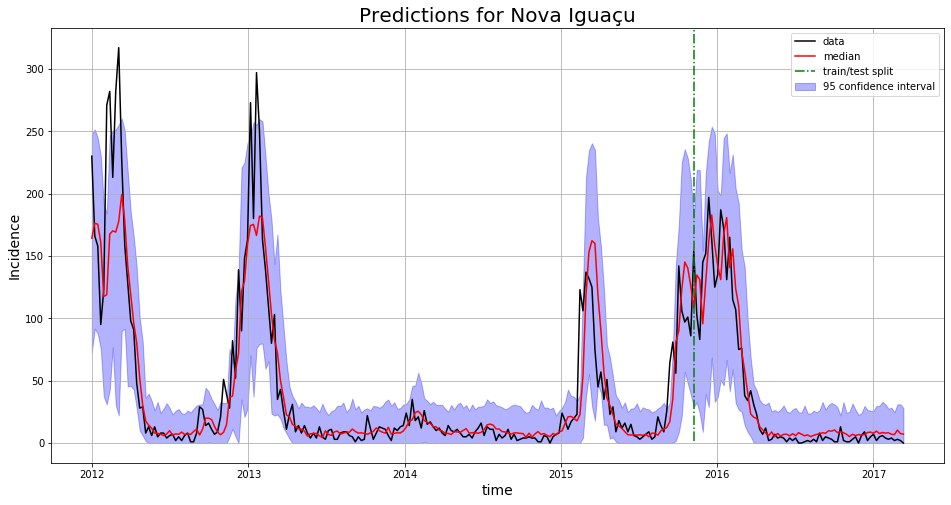

In [68]:
### formatting data and loading model
X, y = np.concatenate((X_train,X_test), axis=0), np.concatenate((y_train,y_test),axis=0)*max_values.iloc[0]

timestamps = data.index[:len(X)]
predictions = make_predictions_batch(X, model, hidden=4, features=7, predict_n = 1, look_back=10,\
                                          batch_size=1,n_pred = 100)*max_values.iloc[0]

### Plotting
plot="median"
confidence=95
data_kw={"label": "data","color":"black"}
pred_kw = {"color":"red"}
fill_kw={"color":"blue","alpha":0.3,"label": "{} confidence interval".format(confidence)}
title_kw={"label": "Predictions for Nova Iguaçu","fontsize":20}
xlabel_kw = {"xlabel": "time","fontsize":14}
ylabel_kw={"ylabel":"Incidence","fontsize":14}
axvline_kw={"x": timestamps[len(X_train)], "linestyle": "dashdot", "ymin":0.05,"ymax":1, "color": "g", "label":"train/test split"}
grid_params={}

fig, ax = plt.subplots(figsize=(16,8))
plot_quantiles(ax,timestamps, predictions[:,:,0],y[:,0],plot,confidence,data_kw,pred_kw,fill_kw,\
               title_kw,xlabel_kw,ylabel_kw,axvline_kw)
### saving figure
fig.savefig("../figures/LSTM_{}_dropout.png".format(geocodes["n_iguacu"]))